In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [6]:
import sys
import os
current_dir = os.path.dirname(os.path.abspath('__file__'))  # 去掉文件名，返回文件所在的目录路径
project_root = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(project_root)

from myfunc import train_ch3, train_epoch_ch3

In [2]:
# 生成数据集
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)  # 分配大量空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))  # (200, 1)
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))  # (200, 20)
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)   # gamma(n) = (n-1)!
labels = np.dot(poly_features, true_w)  # 每一行（每个样本）的20个特征和true_w做点积，得到(200, 1)
labels += np.random.normal(scale=0.1, size=labels.shape)  # 为了命名统一，这里scale就是std的意思



In [3]:
# 将NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
        torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[0.3739],
         [0.7909]]),
 tensor([[1.0000e+00, 3.7394e-01, 6.9915e-02, 8.7147e-03, 8.1469e-04, 6.0929e-05,
          3.7973e-06, 2.0285e-07, 9.4817e-09, 3.9395e-10, 1.4731e-11, 5.0079e-13,
          1.5605e-14, 4.4888e-16, 1.1990e-17, 2.9889e-19, 6.9854e-21, 1.5365e-22,
          3.1921e-24, 6.2823e-26],
         [1.0000e+00, 7.9089e-01, 3.1275e-01, 8.2452e-02, 1.6303e-02, 2.5787e-03,
          3.3991e-04, 3.8405e-05, 3.7968e-06, 3.3365e-07, 2.6388e-08, 1.8973e-09,
          1.2504e-10, 7.6074e-12, 4.2976e-13, 2.2659e-14, 1.1201e-15, 5.2109e-17,
          2.2896e-18, 9.5306e-20]]),
 tensor([5.3684, 5.3881]))

In [4]:
# 对模型进行训练和测试

In [5]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和，样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [11]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))  # 多项式中包含了偏置项（第一个feature）
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', xlim=[1, num_epochs],
                            ylim=[1e-3, 1e2],
                            legend=['train', 'test'])  # 画图：train loss 和 test loss（每20epoch）
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch+1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.011783   1.1859255 -3.4140315  5.607759 ]]


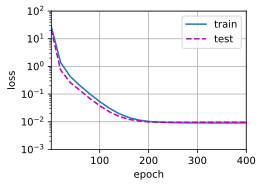

In [ ]:
# 三阶多项式函数拟合（正常）
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

weight: [[3.3438232 3.8163817]]


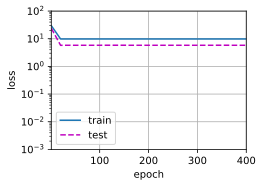

In [13]:
# 欠拟合
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

weight: [[ 5.001608    1.2852184  -3.3686442   5.061778   -0.10586765  1.5345467
   0.36455187  0.329906    0.19337337  0.2231061  -0.02414316  0.20083283
  -0.03387664  0.04175696  0.01671685 -0.18849888  0.03403957 -0.04798382
   0.20195639 -0.12577528]]


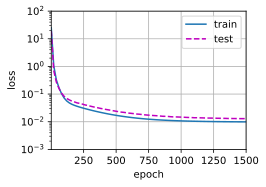

In [15]:
# 过拟合
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:], num_epochs=1500)